In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import datetime as datetime
from timeit import default_timer as timer

In [2]:
data_pre = pd.read_csv("Slow_amp_pre.csv", header=None)
data_post = pd.read_csv("Slow_amp_post.csv", header=None)
data_whole = pd.read_csv("Slow_amp_whole.csv", header=None)

n_rows = data_pre.shape[0]
n_cols = data_whole.shape[1] - (data_pre.shape[1] + data_post.shape[1])

data_miss = pd.DataFrame(np.zeros([n_rows, n_cols])*np.nan)

In [3]:
data_post.shape

(33, 1521)

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
print(data_whole.shape)
print(data_pre.shape)
print(data_post.shape)
print(data_miss.shape)

(33, 3133)
(33, 1563)
(33, 1521)
(33, 49)


In [6]:
data_pre_vals = data_pre[:].values
data_post_vals = data_post[:].values
data_whole_vals = data_whole[:].values

In [7]:
dummy_data = pd.concat([data_pre, data_post], axis=1,ignore_index=True)

In [8]:
data = scaler.fit_transform(dummy_data[:].values.reshape(-1,1)).reshape(dummy_data.shape[0],dummy_data.shape[1])

<ipython-input-9-2020cab4562a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


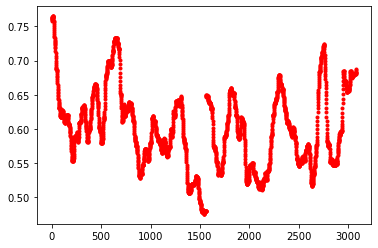

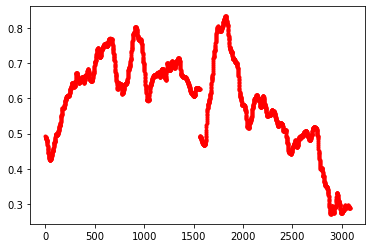

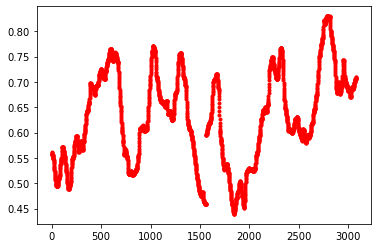

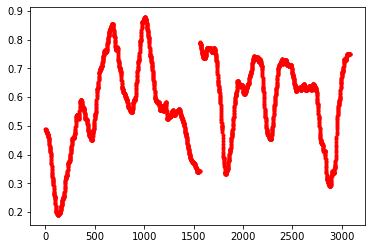

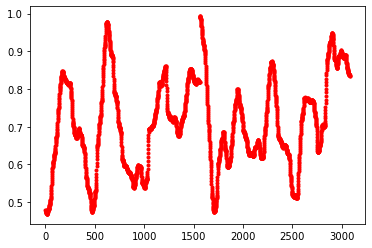

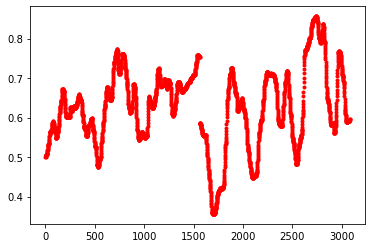

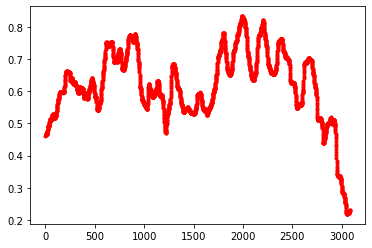

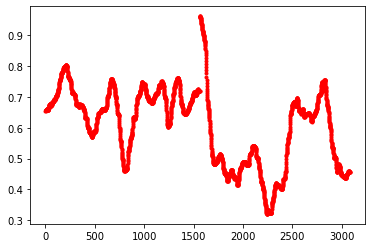

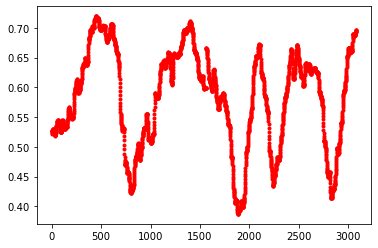

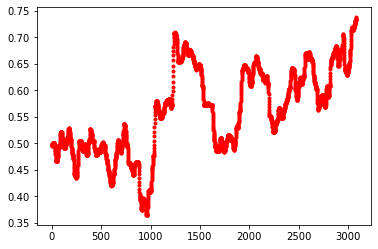

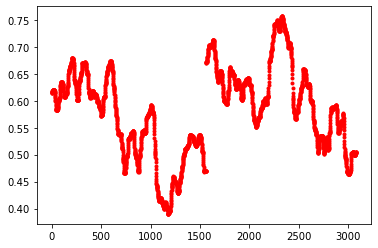

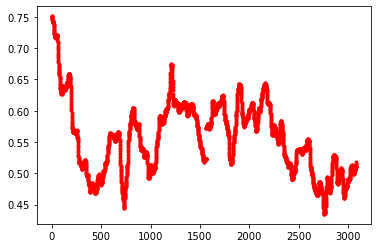

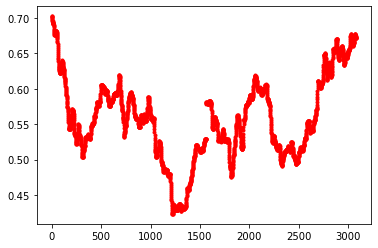

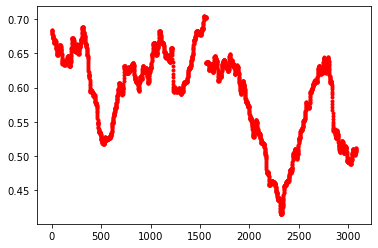

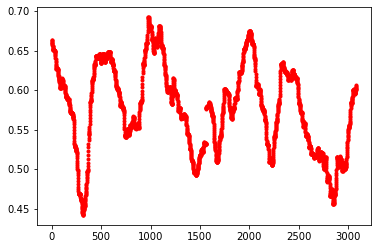

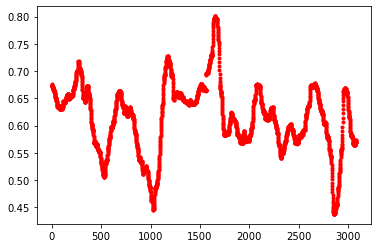

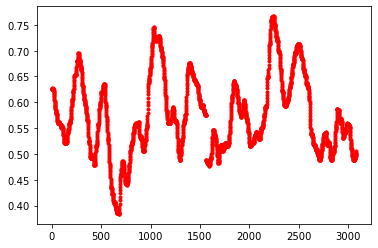

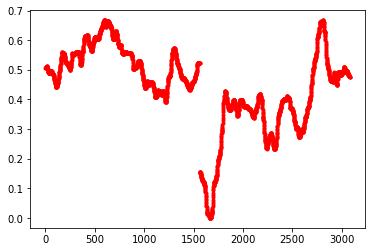

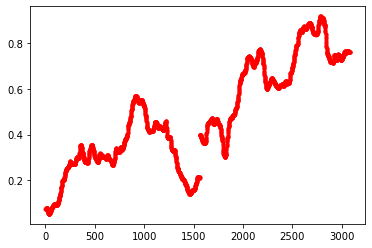

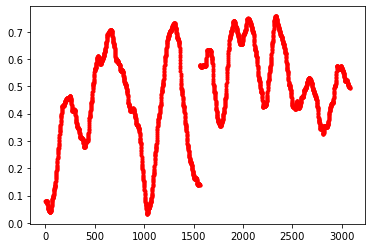

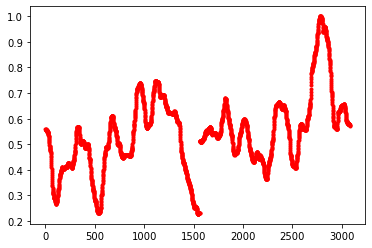

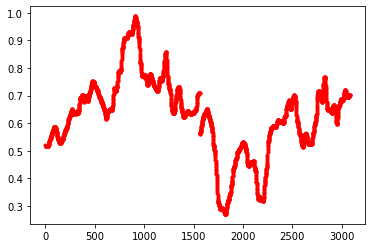

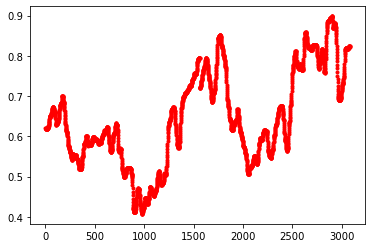

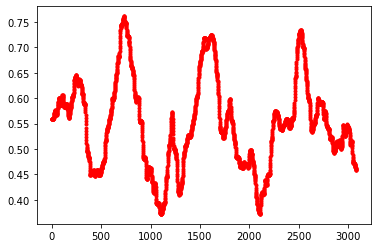

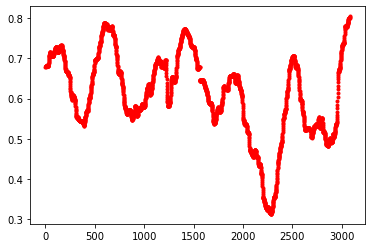

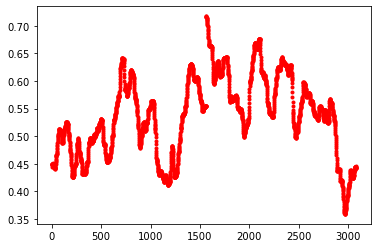

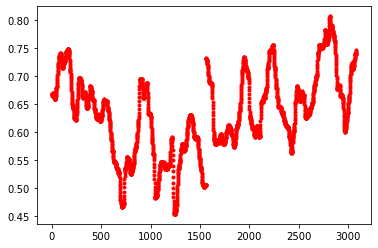

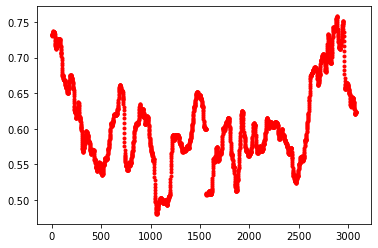

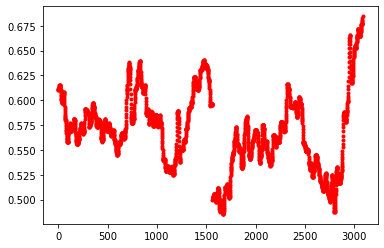

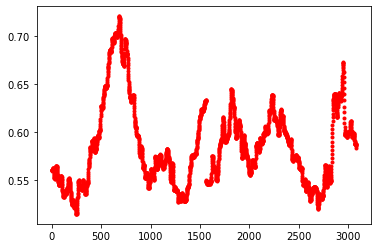

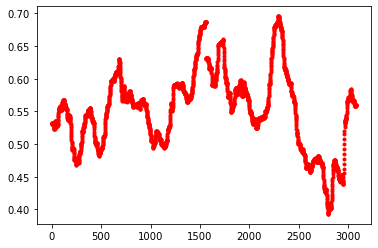

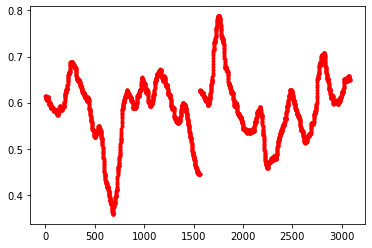

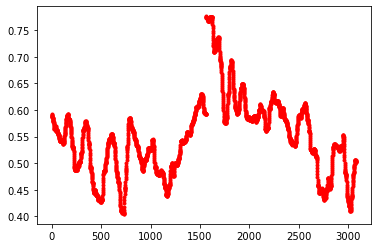

In [9]:
for i in range(len(data)):
    plt.figure(i)
    plt.plot(data[i,:],'r.')

In [10]:
data.shape

(33, 3084)

In [11]:
data_pre.shape[1]+n_cols

1612

In [12]:
pre_data_scaled = data[:,:data_pre.shape[1]]
post_data_scaled = data[:, data_pre.shape[1]:data.shape[1]]

In [13]:
pre_data_scaled.shape

(33, 1563)

<ipython-input-14-921212380514>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


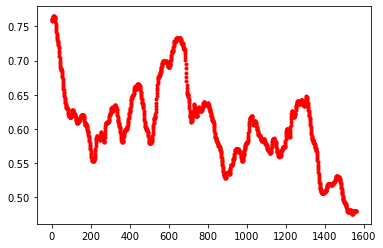

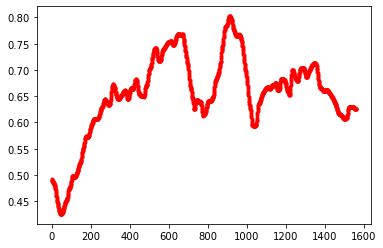

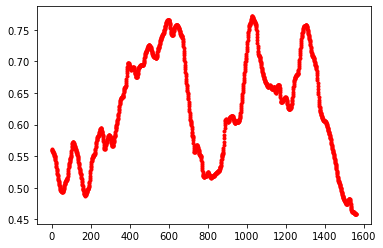

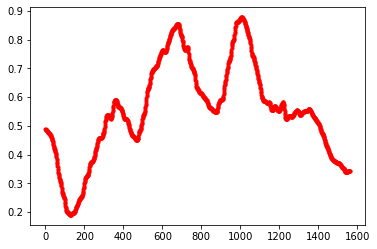

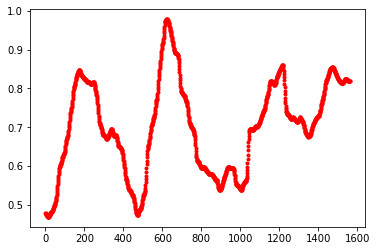

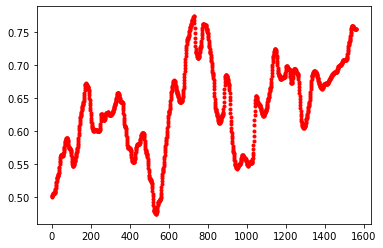

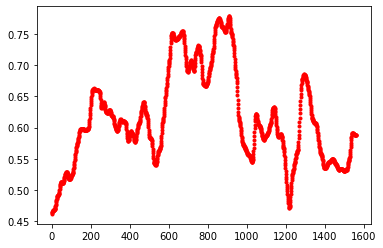

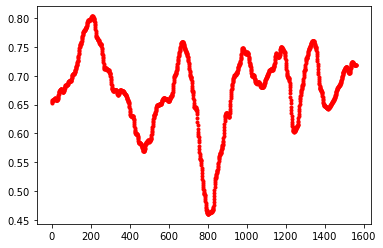

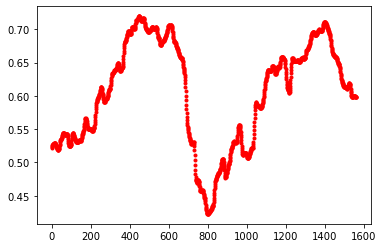

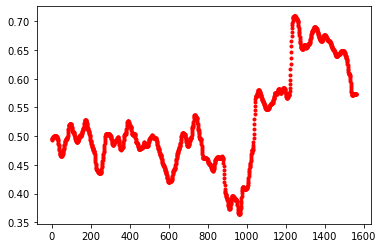

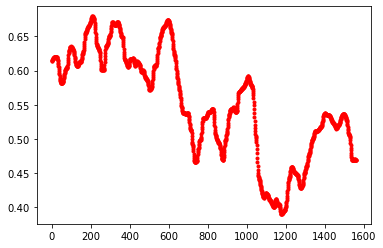

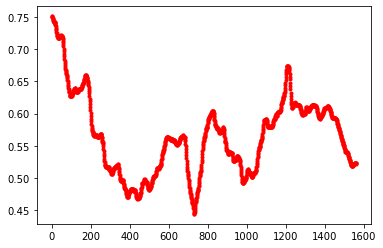

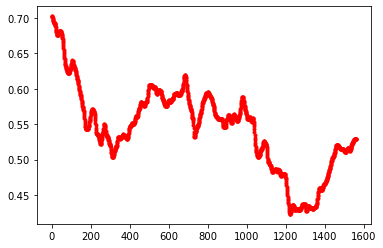

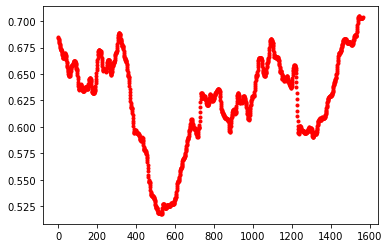

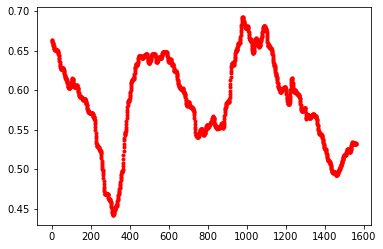

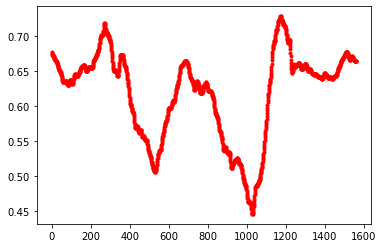

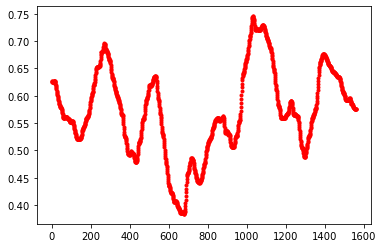

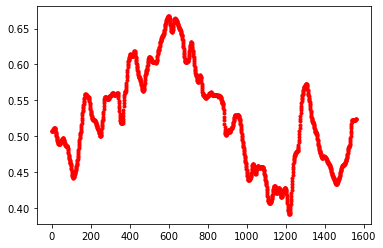

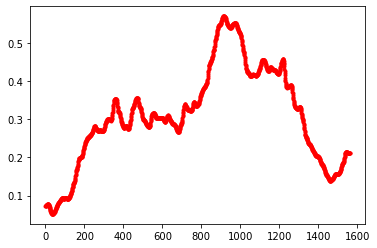

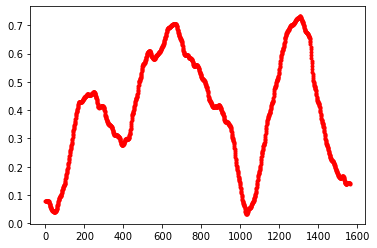

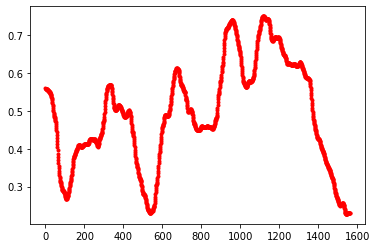

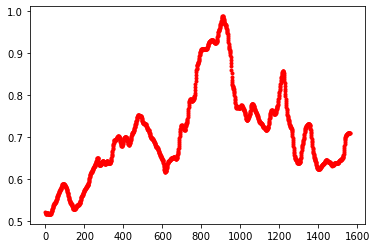

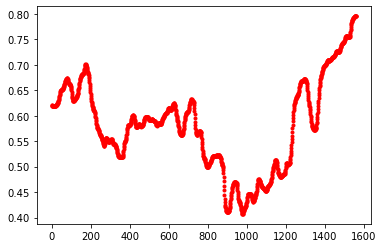

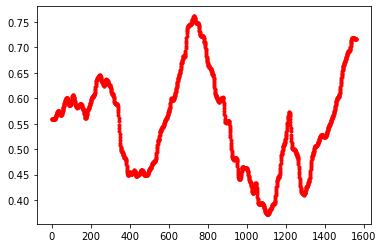

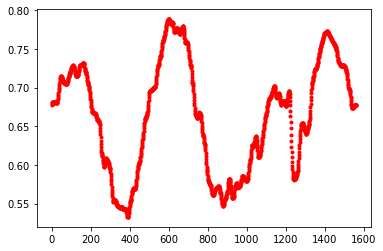

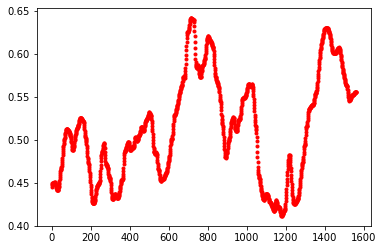

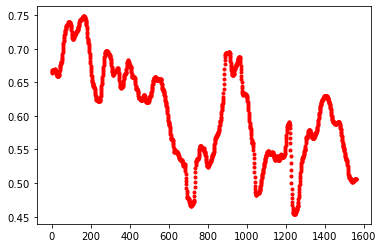

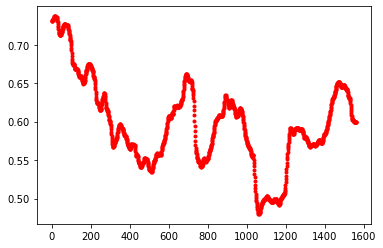

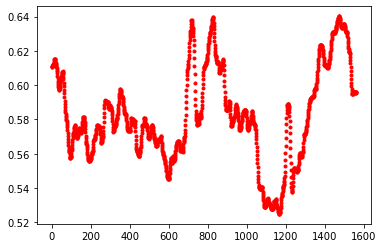

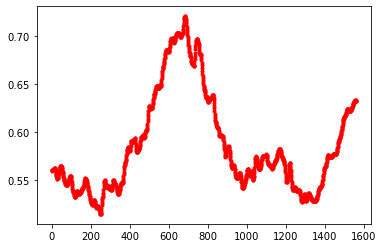

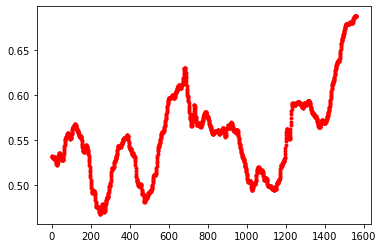

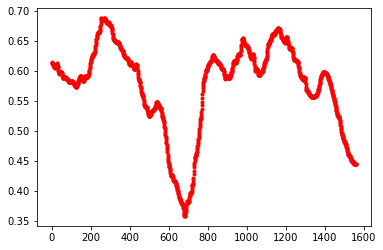

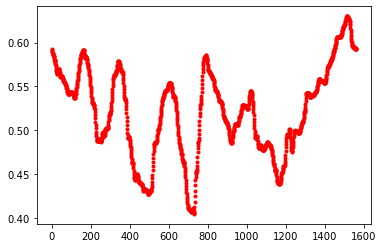

In [14]:
for i in range(len(pre_data_scaled)):
    plt.figure(i)
    plt.plot(pre_data_scaled[i,:],'r.')

In [15]:
full_data = np.concatenate((pre_data_scaled, data_miss, post_data_scaled), axis=1)

In [16]:
full_data.shape

(33, 3133)

<ipython-input-17-3b59dcca165f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


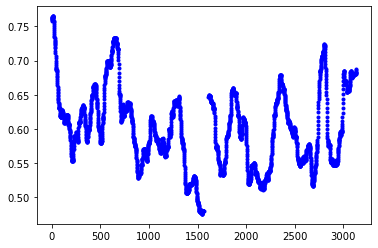

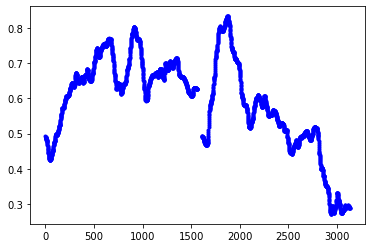

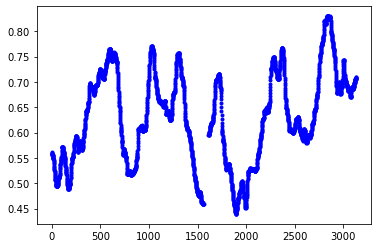

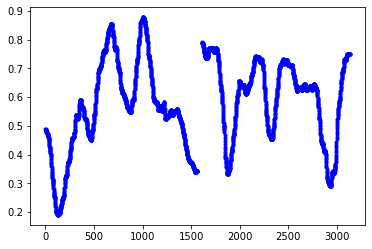

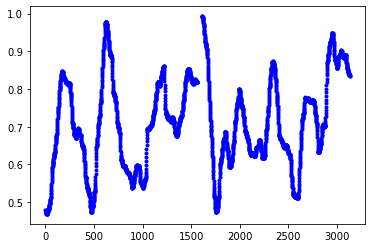

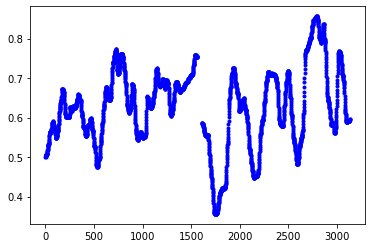

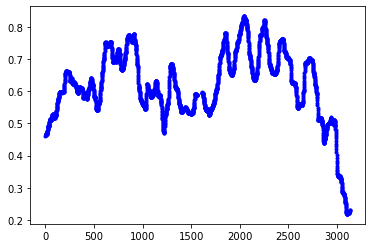

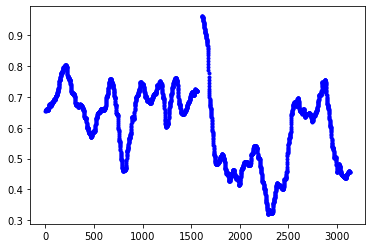

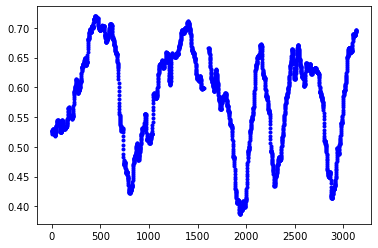

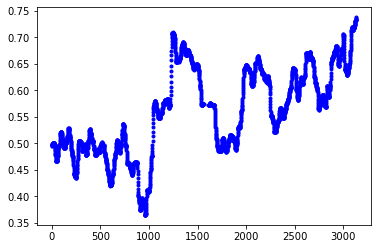

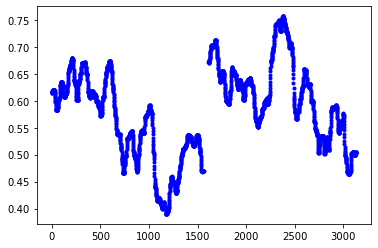

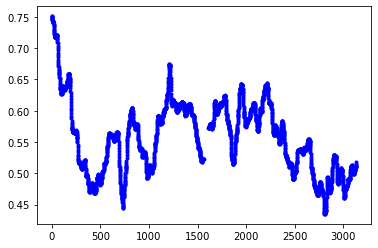

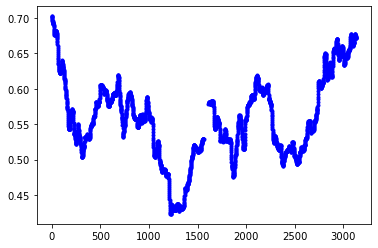

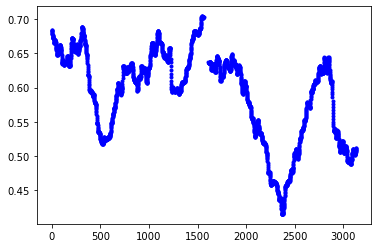

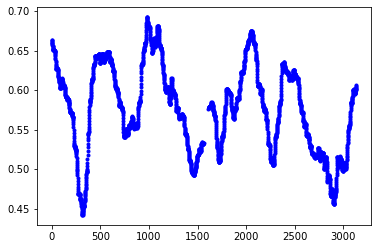

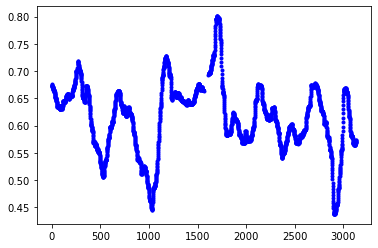

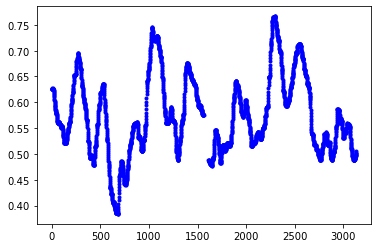

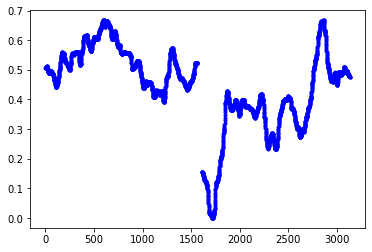

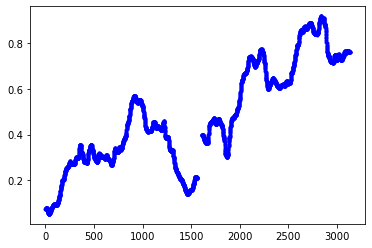

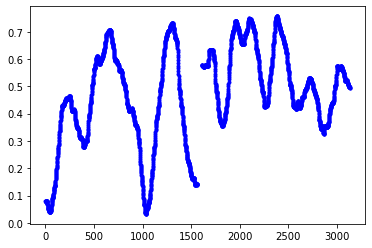

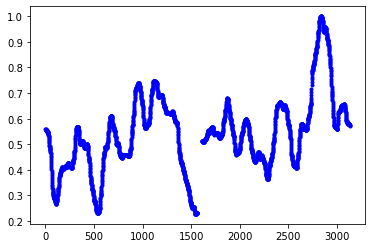

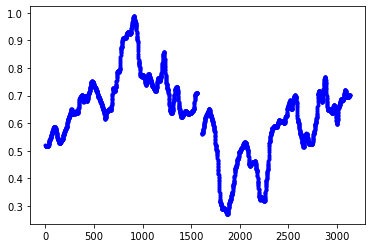

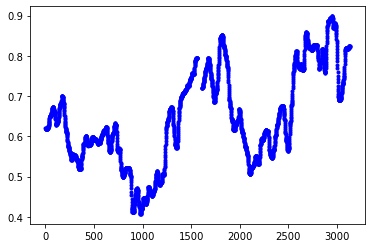

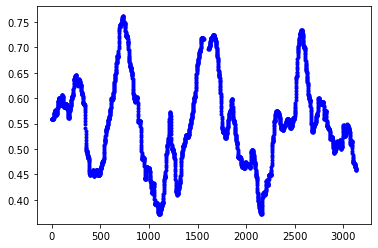

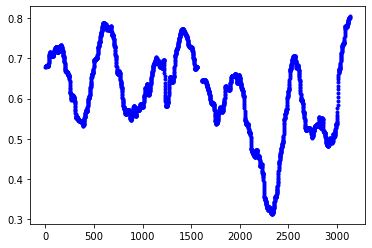

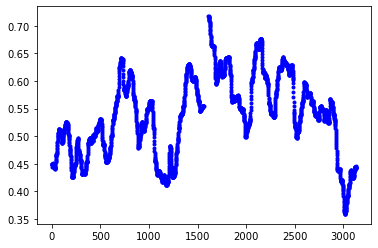

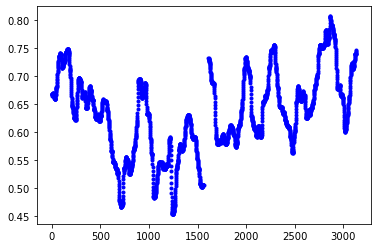

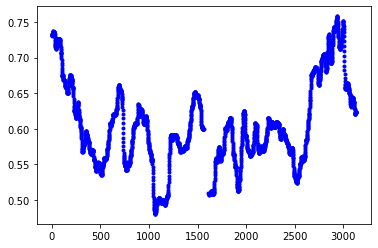

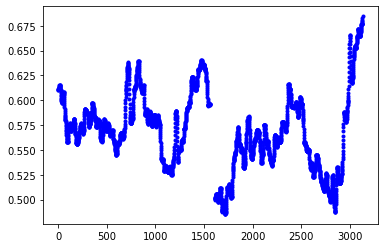

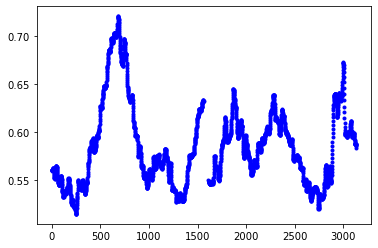

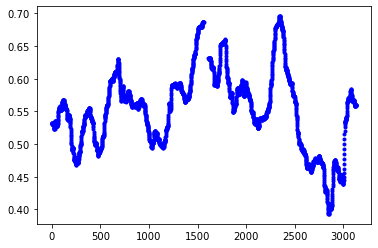

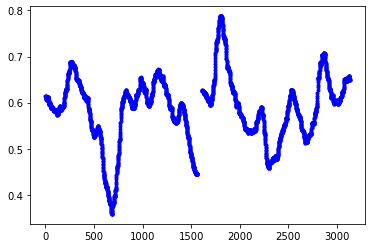

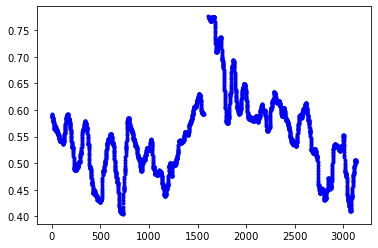

In [17]:
for i in range(len(full_data)):
    plt.figure(i)
    plt.plot(full_data[i,:],'b.')

In [18]:
np.count_nonzero(np.isnan(full_data))

1617

In [19]:
def generateLaggedDf(df, training_len, missing_len, col_name):
    df_new = df.copy()
    for i in range(1,training_len + missing_len):
        df_new[f"Lag{i}"] = df[[col_name]].shift(i)
    df_new = df_new.iloc[training_len + missing_len:]
    
    df_new = df_new.dropna(axis= 0)
    
    mid_df = int(0.5 * len(df_new))
    
    df_1 = df_new[:mid_df]
    df_2 = df_new[mid_df:]
   
    train_len1 = int(0.8 * len(df_1))
    train_len2 = int(0.8 * len(df_2))
    
    df_train1 = df_1[:train_len1]
    df_val1 = df_1[train_len1:]
    
    df_train2 = df_2[:train_len2]
    df_val2 = df_2[train_len2:]
    
    df_train = df_train1.append(df_train2, ignore_index = True)
    df_val = df_val1.append(df_val2, ignore_index = True)
    
    trainY = df_train.iloc[:,:missing_len]
    trainX = df_train.drop(df_train.iloc[:,:missing_len], axis=1)
    
    valY = df_val.iloc[:,:missing_len]
    valX = df_val.drop(df_train.iloc[:,:missing_len], axis=1)
    
    return trainX, trainY, valX, valY

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim,  output_dim, dropout_prob, hidden_dim, layer_dim):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.d_prob = dropout_prob

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Dropout Layer
        self.dropout = nn.Dropout(self.d_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]
        
        out = self.dropout(out)

        out = self.fc(out)

        return out

In [21]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.
    """
    def __init__(self, model, loss_fn, optimizer, patience, min_delta = 1e-6):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.counter = 0
        self.min_delta = min_delta
        self.min_validation_loss = np.inf
        self.patience = patience
        
    def train_step(self, x, y):

        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def earlyStop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
            
        elif validation_loss >= (self.min_validation_loss - self.min_delta):
            self.counter +=1
            if self.counter >= self.patience:
                return True
            return False

    def train(self, train_loader, val_loader, batch_size, n_epochs, mode, n_features, output_dim):

        model_path = f'lstm_mode_{mode}.pt'
        break_out_flag = False

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                if self.earlyStop(validation_loss):
                    break_out_flag = True
                    break               
            
            if break_out_flag:
                torch.save(self.model.state_dict(), model_path)
                break

            #if (epoch % 50 == 0):
            #    print(
            #        f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
            #    )
        torch.save(self.model.state_dict(), model_path)
          
    def evaluate(self, x, test):
        with torch.no_grad():
            predictions = []
            values = []
            for i in range(len(test)):
                x = x.to(device)
                self.model.eval()
                x_test = x.view([1, -1, 100]).to(device)
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(test[i].to(device).detach().numpy())
                #print(x.size())
                #print(yhat.size())
                x=torch.reshape(x,(100,1))
                x = torch.cat((x,yhat),0)
                x = x[1:]

        return predictions, values
    
    def evaluate2(self, x, test, training_len, missing_len):
        with torch.no_grad():
            predictions = []
            values = []
            for j in range(len(test)):
                val = test[j].to(device).cpu()
                values.append(val.detach().numpy())
            
            num = len(test) % missing_len
            if (num == 0):
                for i in range(math.floor(len(test)/missing_len)):
                    x = x.to(device)
                    self.model.eval()
                    x_test = x.view([1, -1, training_len]).to(device)
                
                    yhat = self.model(x_test)
                    yint = torch.reshape(yhat,(missing_len,1))                
                    y_int = yint.to(device).cpu()
                    predictions.append(y_int.detach().numpy())
                    x = torch.reshape(x,(training_len,1))
                    x = torch.cat((x,yint),0)
                    x = x[-training_len:]
            else:
                for i in range(math.floor(len(test)/missing_len)+1):
                    x = x.to(device)
                    self.model.eval()
                    x_test = x.view([1, -1, training_len]).to(device)
                
                    yhat = self.model(x_test)
                    yint = torch.reshape(yhat,(missing_len,1))                
                    y_int = yint.to(device).cpu()
                    predictions.append(y_int.detach().numpy())
                    x = torch.reshape(x,(training_len,1))
                    x = torch.cat((x,yint),0)
                    x = x[-training_len:]
            
        preds =  torch.reshape(torch.Tensor(predictions),(-1,1))
        
        return np.asarray(values), np.asarray(preds)


    def plot_losses(self, training_len):
        """The method plots the calculated loss values for training and validation
        """
        np.savetxt(f"Output_length={training_len}_train.out", self.train_losses, fmt='%1.4e')
        np.savetxt(f"Output_length={training_len}_val.out", self.val_losses, fmt='%1.4e')
        
        plt.figure(figsize=[10,8])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title(f"Losses for output length = {training_len}")
        plt.grid()
        plt.show()
        plt.savefig(f'Losses comparisons for output length={training_len} over epochs.png',dpi=300)
        plt.close()

In [22]:
def get_model(model, model_params):
    models = {
        #"rnn": RNNModel,
        "lstm": LSTMModel,
        #"bi-lstm": BiLSTMModel,
        #"gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [23]:
input_len = 100
output_len = 75

input_dim = input_len
output_dim = output_len
hidden_dim = 128
layer_dim = 2
dropout = 0.4
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class MeanCubeLoss(nn.Module):
    def __init__(self):
        super(MeanCubeLoss, self).__init__()
        
    def forward(self, output, target):
        loss = torch.mean(abs(output-target)**3)
        return loss

In [ ]:
torch.manual_seed(2)

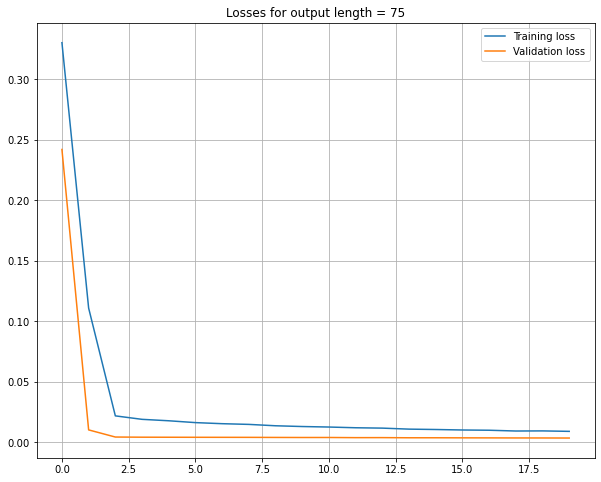

The total duration for the training is 0.1782731416666667 minutes


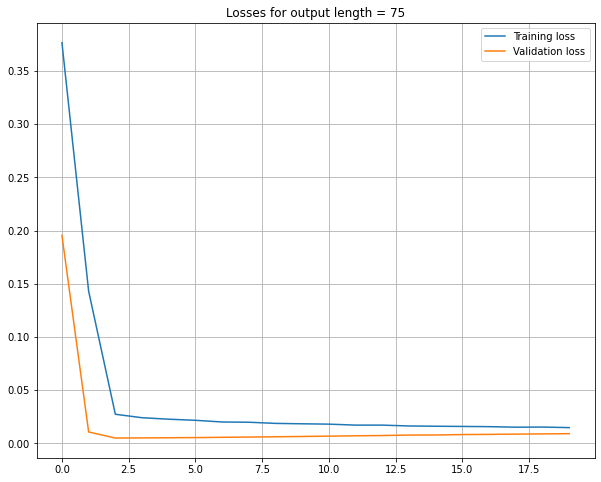

The total duration for the training is 0.1097711833333334 minutes


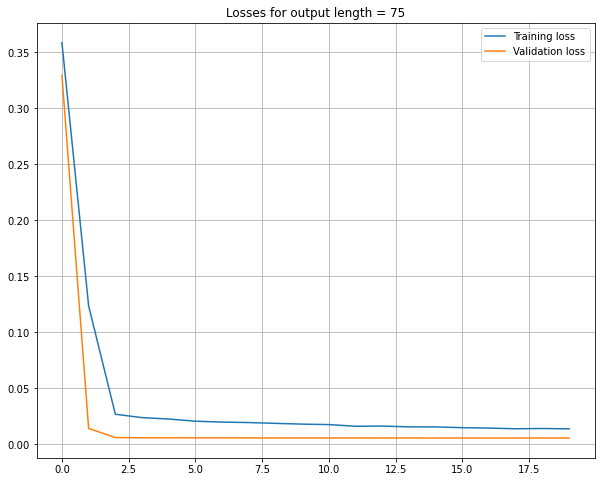

The total duration for the training is 0.11158035833333327 minutes


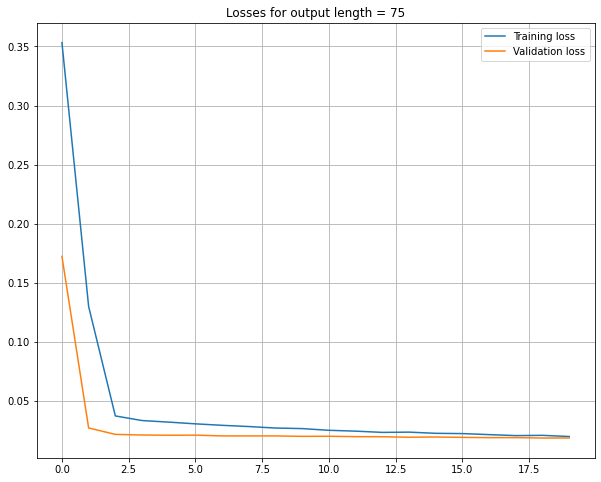

The total duration for the training is 0.11087418333333332 minutes


KeyboardInterrupt: 

In [25]:
for i in range(len(full_data)):
    Eta_Df = pd.DataFrame([])
    df = pd.DataFrame(full_data[i,:], columns = ['Eta'])
    Eta_Df = Eta_Df.append(df, ignore_index = True)
    Train_X, Train_Y, Val_X, Val_Y = generateLaggedDf(Eta_Df, input_len, output_len,'Eta')
    
    X_Train = np.asarray(Train_X.iloc[:,::-1])
    Y_Train = np.asarray(Train_Y.iloc[:,::-1])
    X_Val = np.asarray(Val_X.iloc[:,::-1])
    Y_Val = np.asarray(Val_Y.iloc[:,::-1])
    
    mode = i
    
    Train_features = torch.Tensor(X_Train.copy())
    Train_targets = torch.Tensor(Y_Train.copy())
    Val_features = torch.Tensor(X_Val.copy())
    Val_targets = torch.Tensor(Y_Val.copy())

    train_eta = TensorDataset(Train_features, Train_targets)
    val_eta = TensorDataset(Val_features, Val_targets)
    
    start = timer()
    
    model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

    model = get_model('lstm', model_params)
    model = model.to(device)

    batch_size = 32
    n_epochs = 20

    learning_rate = 1e-4
    loss_fn = nn.MSELoss(reduction="mean")
    #loss_fn = MeanCubeLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    Ftrain_loader = DataLoader(train_eta, batch_size=batch_size, shuffle=False, drop_last=True)
    Fval_loader = DataLoader(val_eta, batch_size=batch_size, shuffle=False, drop_last=True)
    
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, patience = 50)
    opt.train(Ftrain_loader, Fval_loader, batch_size=batch_size, n_epochs=n_epochs, mode=i, n_features=input_dim, output_dim = output_dim)
    opt.plot_losses(output_dim)
            
    end = timer()

    dur = (end-start)/60
    print(f'The total duration for the training is {dur} minutes')

In [ ]:
data_test = scaler.fit_transform(data_whole_vals.reshape(-1,1)).reshape(data_whole_vals.shape[0],data_whole_vals.shape[1])

In [ ]:
Predictions = np.zeros([data_miss.shape[0], data_miss.shape[1]])
Values = np.zeros([data_miss.shape[0], data_miss.shape[1]])
missing_len = data_miss.shape[1]

for i in range(len(Predictions)):
    X_Test = np.asarray(data_test[i,data_pre_vals.shape[1]-input_len:data_pre_vals.shape[1]])
    Y_Test = np.asarray(data_test[i,data_pre_vals.shape[1]:data_pre_vals.shape[1]+missing_len])

    Test_features = torch.Tensor(X_Test)
    Test_targets = torch.Tensor(Y_Test)

    model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

    model = get_model('lstm', model_params)
    model = model.to(device)

    PATH = f'lstm_mode_{i}.pt'
    model.load_state_dict(torch.load(PATH))
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    bl1 = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, patience = 50)
    values, preds = bl1.evaluate2(Test_features,Test_targets, input_len, output_len)
    
    num = len(Test_targets) % output_len

    if (num != 0):
        preds = preds[:len(Test_targets)]
  
    p = np.asarray(preds).reshape(missing_len)
    Predictions[i,:] = p
    Values[i,:] = values
    
Preds_rescaled = scaler.inverse_transform(Predictions.reshape(-1,1)).reshape(Predictions.shape[0],Predictions.shape[1])
Vals_rescaled = scaler.inverse_transform(Values.reshape(-1,1)).reshape(Predictions.shape[0],Predictions.shape[1])

np.savetxt("Pred_All.out", Preds_rescaled)
np.savetxt("Vals_All.out", Vals_rescaled)

In [ ]:
plt.figure(figsize=[10,10])
for i in range(len(Predictions)):
    plt.plot(Preds_rescaled[i,:])

In [ ]:
for i in range(len(Predictions)):
    plt.figure(i)
    plt.plot(Preds_rescaled[i,:],'b.')
    plt.plot(Vals_rescaled[i,:],'r.')
    plt.savefig(f'Preds and Vals comparisons_{i}')